# DTW-MDM on synthetic data

In this notebook, we show how to reproduce the results of the paper _AVERAGING TRAJECTORIES ON MANIFOLD OF COVARIANCE MATRICES_ on the synthetic. We will provide the code we used to generate the datasets as well as an example of comparaison of the two algorithms proposed in the paper : DTW-MDM, PT-MDM. We will also compare them to the MDM introduced in [1]. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pymanopt
import pymanopt.manifolds
from pyriemann.utils.distance import distance_riemann
from pyriemann.classification import MDM

import scipy.stats as stat

from dtw_mdm import DTW_MDM,PT_MDM
from utils import *
np.random.seed(2)

Let us start by defining two utilitary funcitons.

In [2]:
def sample_cov(nb,dim,scale):
    """ Sampling nb SPD matrices the following :
    U is drawn from the O(dim) Haar distribution
    D is a diagonal matrix and has strictly positive values drawn from a uniform distribution U[0, scale]
    The sampled matrix is the U^TDU
    
    Parameters
    -------------
    nb : int
        The number of sampled SPD matrices.
    dim : int
        The dimension of the sampled SPD matrix
    scale : float
        The scale of the uniform distribution used.

    Returns
    -------------
    all_mat : array_like of size (nb, dim, dim)
        The sampled random SPD matrices.

    """
    all_mat = []
    for i in range(nb):
        U = stat.ortho_group.rvs(dim)
        r = stat.uniform.rvs(scale=scale,size=dim)
        all_mat.append(U.T@np.diag(np.exp(r))@U)
    return np.array(all_mat)

In [3]:
def random_trajectories(l, all_M, scale_noise):
    """ Creates a random trajectory with the procedure described in the paper.
    
    Parameters
    -------------
    l : int
        The number of points on the desired trajectory.
    all_M : array_like of size (N, c, c)
        The SPD matrices forming the underlying trajectory.
    scale_noise : float
        The scale of the noise added to the trajectory.

    Returns
    -------------
    traj : array_like of size (l, c, c)
        The sampled random trajectory following the underlying trajectory.
    
    """
    n_M = len(all_M)
    n = all_M[0].shape[0]
    all_t = stat.uniform.rvs(size = l)
    all_t = np.sort(all_t)
    traj = []
    for t in all_t:
        i = 0
        while t > (i+1)/(n_M-1):
            i += 1
        v = manifold.log(all_M[i],all_M[i+1])
        epsilon = stat.norm.rvs(scale=scale_noise, size=n)
        t_tilde = (t - i/(n_M-1))*((n_M-1))
        traj.append(exp(all_M[i],t_tilde*v) + epsilon.reshape(n, 1) @ epsilon.reshape(1, n)) 
    return np.array(traj)

We can now generate the trajectories that we will then classify.

In [4]:
c = 2 # The dimension of the matrices
l = 10 # The number of points on the trajectories
scale_noise = 1/2 # The additive gaussian noise 
N = 5 # The number of points on the underlying trajectory.
n = 100 # The number of trajectories per class
manifold = pymanopt.manifolds.SymmetricPositiveDefinite(n=c)

In [5]:
# We start by defining the two underlying trajectories
big_M1 = sample_cov(2,c,5)
all_M1 = random_trajectories(N,big_M1,scale_noise)
all_M2 = all_M1.copy()
all_M2[3] += sample_cov(1,c,5)[0]

# We can then sample the training trajectories 
all_traj1 = []
all_traj2 = []
for i in range(n):
    all_traj1.append(random_trajectories(l,all_M1,scale_noise))
    all_traj2.append(random_trajectories(l,all_M2,scale_noise))
all_traj1 = np.array(all_traj1)
all_traj2 = np.array(all_traj2)
all_traj = np.concatenate((all_traj1,all_traj2))
labels = np.array([1]*all_traj1.shape[0] + [2]*all_traj1.shape[0])

Then, we can classify the trajectories using the three algorithms : DTW-MDM, Traj MDM and MDM.

In [6]:
nb_it = 10
eps = 1e-5

# We start by shuffling the trajectories and by diving the set into a training and a testing set.
size_mean_traj = all_traj1.shape[1]
idx_shuffle = np.arange(len(all_traj))
np.random.shuffle(idx_shuffle)
all_traj_shuffle = all_traj[idx_shuffle]
labels_shuffle = labels[idx_shuffle]

pourcent_train = 0.8
training_traj = all_traj_shuffle[:int(len(all_traj_shuffle)*pourcent_train)]
training_labels = labels_shuffle[:int(len(all_traj_shuffle)*pourcent_train)]

testing_traj = all_traj_shuffle[int(len(all_traj_shuffle)*pourcent_train):]
testing_labels = labels_shuffle[int(len(all_traj_shuffle)*pourcent_train):]

We train the classifiers.

In [7]:
print("Training the DTW-MDM...")
DTW_MDM_ = DTW_MDM(manifold, nb_it, eps, size_mean_traj)
DTW_MDM_.fit(training_traj,training_labels)
print("Training of the DTW-MDM done !")

print("Training the PT MDM...")
PT_MDM = PT_MDM(manifold)
PT_MDM.fit(training_traj,training_labels)
print("Training of the PT MDM done !")

print("Training the MDM...")
MDM_ = MDM(n_jobs=-1)
average_traj =  np.mean(all_traj_shuffle,axis=1)
MDM_.fit(np.mean(training_traj,axis=1),training_labels)
print("Training of the MDM done !")

Training the DTW-MDM...


100%|██████████| 10/10 [01:22<00:00,  8.21s/it]


Training of the DTW-MDM done !
Training the PT MDM...
Training of the PT MDM done !
Training the MDM...
Training of the MDM done !


And test them

In [8]:
score_DTW_MDM = DTW_MDM_.score(testing_traj,testing_labels)
score_PT_MDM = PT_MDM.score(testing_traj,testing_labels)
score_MDM = MDM_.score(np.mean(testing_traj,axis=1),testing_labels)

We can plot the different accuracy on this simple example. We see that the two proposed algorithms _DTW-MDM_ and _PT-MDM_ have a better accuracy than the state of the art algorithm _MDM_ [1]. 

[]

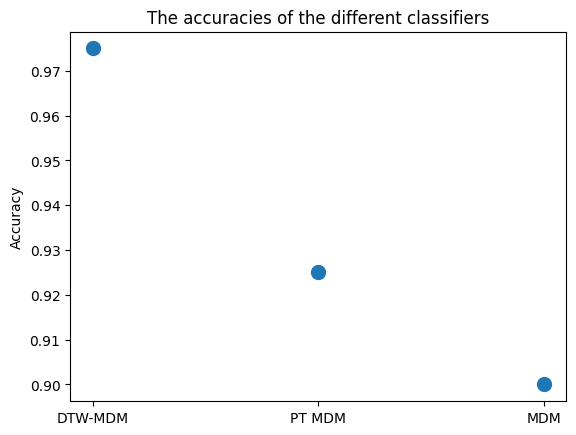

In [9]:
plt.figure()
plt.plot([score_DTW_MDM,score_PT_MDM,score_MDM],'o',markersize=10)
plt.xticks(ticks=[0,1,2],labels=["DTW-MDM", "PT MDM", "MDM"])
plt.ylabel("Accuracy")
plt.title("The accuracies of the different classifiers")
plt.plot()

### References


[1] A. Barachant, S. Bonnet, M. Congedo, and C. Jutten, “Riemannian geometry applied to BCI classification,” in _LVA/ICA 2010_. Sept. 2010, vol. 6365, p. 629, Springer.